# Objective function `the best place for the company to grow`

##### Objective function ->

X (var independient): Val_by_place Each place will be assigned with a value in each component (9 x 1)

Constants: 
     - Total personal (9 x 1)
     - Valoration of the contribution to grow by role (9 x 1)
     - Rel_personal_Val_place represent the relation between condition and personal (9 x 9)

Any places will be valuated with the next equation:

             `Constants`                      `Independient Variable`

F   =    (   Personal   *   Val_to_grow   *   Rel_personal_Val_place  )    *    Val_by_place

In [1]:
import numpy as np
import json
from pymongo import MongoClient
import pandas as pd

import sys
sys.path.insert(0, 'src/')

from funobjetivo import valor


In [2]:
# Example of using function objective
Val_by_place={"other Design companies":0.1,
         "kindergarden":0.2,
         "success startup":0.5,
         "Starbucks":1,
         "Airport_or_train_station":2,
         "place_to party":2,
         "basqueball court":1,
         "no_2km_old_company":0.8,
         "vegan_restaurant":0.5}

valor(**Val_by_place)

2255.75

# Getting data

## Other design companies

In [3]:
# Connect and get the data --> Categories
url_mongo="mongodb://localhost:27017"
client = MongoClient(url_mongo)
db = client.get_database("companies")
result=list(db.companies.find({},{"category_code":1,"_id":0}))
categories=[e['category_code'] for e in result]

In [4]:
# Count the number of design comanies and include Web 
categorias= pd.DataFrame(categories)
categorias=categorias.rename(columns={0:"categoria"})
len(categorias.categoria.value_counts())
# -->  41 categories
len(categorias.categoria[categorias.categoria=="design"]) 
# --> just 4 companies!!
len(categorias.categoria[categorias.categoria=="web"]) 
# --> 3787.. is web companies equivalent to design 
#     companies in this context?

3787

In [139]:
# Getting the ubication of the offices of design and web companies
query={"$or":[{"category_code":"design"},{"category_code":"web"}]}
offices=list(db.companies.find(query,{"name":1,"offices":1,"_id":0}))
offices=pd.DataFrame(offices)
offices=offices.explode("offices")

NameError: name 'db' is not defined

In [6]:
# Extracting Lat an Long
def json_column(row):
    of=row.offices
    if type(of)==float or of["latitude"] is None:
        return (row['name'],"theres is no data ",None, None)
    return (row['name'],"success",of["latitude"] ,of["longitude"])

offices_coor_name = offices.apply(json_column, axis=1, result_type='expand')
offices_coor_name# = pd.concat([offices.name,offices_coor])

,0,1,2,3
0,Wetpaint,success,47.603122,-122.333253
0,Wetpaint,success,40.723731,-73.996431
1,Postini,success,37.506885,-122.247573
2,Geni,success,34.090368,-118.393064
3,Fox Interactive Media,success,34.076179,-118.394170
...,...,...,...,...
3786,iGuiders,theres is no data,NaN,NaN
3787,Zoomission,theres is no data,NaN,NaN
3788,Eazeeloans,theres is no data,NaN,NaN
3789,DocASAP,theres is no data,NaN,NaN


In [7]:
offices_coor_name=offices_coor_name.rename(columns={0:'name',1:'State_coor',2:'latitude',3:'longitud'} )
offices_coor_name=offices_coor_name[offices_coor_name['State_coor']=="success"] 
# --> 2311 companies with coordenates

In [8]:
# Setting the format for MongoDB index
def coor_jgeo(row):
     return {'type':'Point','coordinates':[row['longitud'],row['latitude']]}

offices_coor_name['design_coor']=offices_coor_name.apply(coor_jgeo,axis=1)

In [9]:
offices_coor_name.to_json('output/design.json',orient="records")

## Success startup

In [10]:
# Query for getting the rounds data
query={"funding_rounds.0.raised_amount":{"$gt":0}}

fund=list(db.companies.find(query,{"name":1,"funding_rounds":1,"_id":0}))
fund=pd.DataFrame(fund)
fund=fund.explode("funding_rounds") # several rounds...

In [11]:
# Creating columns or Raised amount and currency
def extract_round(var):
    return var['raised_amount']

def extract_currency(var):
    return var['raised_currency_code']

fund['val_round']=fund.funding_rounds.apply(extract_round)
fund['val_currency']=fund.funding_rounds.apply(extract_currency)

In [12]:
# Currencies of the Rounds
fund.groupby(['val_currency']).count()

,name,funding_rounds,val_round
val_currency,,,
CAD,43,43,43
EUR,336,336,336
GBP,151,151,151
JPY,12,12,12
SEK,1,1,1
USD,10145,10145,10003


In [13]:
# Creating the rounds in USD--> (average currency exchange last 5Y)
def calculate_usd(row):
    if row['val_round'] is None or row['val_currency'] is None:
        return 0
    
    currecy_equi={'CAD':0.8,'EUR':1.2,'GBP':1.5,'JPY':0.01,'SEK':0.15,'USD':1}
    val=row['val_round'] * currecy_equi[row['val_currency']]

    return val

fund['Val_round_USD']=fund.apply(calculate_usd,axis=1)

Here we have the startups that have funds greater than 1 million dollars

In [14]:
fund=fund[['name','Val_round_USD']].groupby(['name']).sum()
fund=fund.loc[fund.Val_round_USD>1e6]
# --> 3686 companies with more than a millon raised

##### Now find the Lat Long

In [15]:
query={"funding_rounds.0.raised_amount":{"$gt":0}}

ss_point=list(db.companies.find(query,{"name":1,"offices":1,"_id":0}))
ss_point=pd.DataFrame(ss_point)
ss_point=ss_point.explode('offices')

In [16]:
ss_coor=ss_point.apply(json_column, axis=1, result_type='expand')
ss_coor=ss_coor.rename(columns={0:'name',1:'State_coor',2:'latitude',3:'longitud'} )
ss_coor.State_coor.value_counts()

success               3815
theres is no data     2193
Name: State_coor, dtype: int64

In [17]:
ss_coor=ss_coor.loc[ss_coor.State_coor=="success"]
# --> 3815 points of succesful companies
ss_coor.columns

Index(['name', 'State_coor', 'latitude', 'longitud'], dtype='object')

In [18]:
# Setting the format for MongoDB index and export json
ss_coor['success_coor']=ss_coor.apply(coor_jgeo,axis=1)
ss_coor.to_json('output/success.json',orient="records")

## Old Companies

In [19]:
# Query for getting the founded year
query={"founded_year":{"$lt":2010}}

old=list(db.companies.find(query,{"name":1,"offices":1,"_id":0}))
old=pd.DataFrame(old)
old=old.explode("offices") # several offices
old

,name,offices
0,AdventNet,"{'description': 'Headquarters', 'address1': '4..."
1,Wetpaint,"{'description': '', 'address1': '710 - 2nd Ave..."
1,Wetpaint,"{'description': '', 'address1': '270 Lafayette..."
2,Zoho,"{'description': 'Headquarters', 'address1': '4..."
3,Omnidrive,"{'description': '', 'address1': 'Suite 200', '..."
...,...,...
12985,Oriact,"{'description': '', 'address1': 'LÃ¤rchenweg 7..."
12986,Adhunk,"{'description': 'Indian Office', 'address1': '..."
12987,AfterLogic,"{'description': 'Livingston', 'address1': 'P.O..."
12988,Contemporary Computer Services,"{'description': '', 'address1': '200 Knickerbo..."


In [20]:
old=old.apply(json_column, axis=1, result_type='expand')
old=old.rename(columns={0:'name',1:'State_coor',2:'latitude',3:'longitud'} )
old.State_coor.value_counts()

success               9039
theres is no data     6725
Name: State_coor, dtype: int64

In [21]:
old=old.loc[old.State_coor=="success"]
# --> 9039 points of old companies (<2010!!)
old.columns

Index(['name', 'State_coor', 'latitude', 'longitud'], dtype='object')

In [22]:
# Setting the format for MongoDB index and export it
old['success_coor']=old.apply(coor_jgeo,axis=1)
old.to_json('output/old.json',orient="records")

## Importing from API google maps

In [23]:
import requests 
import json
import os 

from dotenv import load_dotenv
load_dotenv()
import sys
sys.path.insert(0, 'src/')
import apiquery # module with the db data

##### --> Cities to import 

We are going to limit the search to specific cities:

* Madrid (40.416977, -3.703827)
* New York (40.7142715 ,-74.0059662)
* Berlin (52.5243683, 13.4105301)
* Seatle (47.6062088, -122.3320694)

In [24]:
# *** Función que consulta el API de google y crea archivos locales para consulta
# Esta función fue usada inicialmente, ahora no es necesaria para la herramienta,
# esta consulta cada vez que ejecuta una iteración a la API de google

#apiquery.genera_bd() 

True

In [1]:
# The research is by city:
import sys
sys.path.insert(0, 'src/')
import research_tool

point_madrid=(40.416977, -3.703827)

Val_by_place={"other Design companies":research_tool.val_design(point_madrid),
         "kindergarden":research_tool.val_kindergarden(point_madrid),
         "success startup":research_tool.val_succ(point_madrid),
         "Starbucks":research_tool.val_starbucks(point_madrid),
         "Airport_or_train_station":research_tool.val_airport(point_madrid),
         "place_to party":research_tool.val_party(point_madrid),
         "basqueball court":research_tool.val_basquet(point_madrid),
         "no_2km_old_company":research_tool.val_old(point_madrid),
         "vegan_restaurant":research_tool.val_vegetariano(point_madrid)}


In [2]:
Val_by_place

{'other Design companies': 1,
 'kindergarden': 0.8153250994316722,
 'success startup': 1,
 'Starbucks': 0.9964265543431481,
 'Airport_or_train_station': 0.9991338996407294,
 'place_to party': 1,
 'basqueball court': 1,
 'no_2km_old_company': 0.00026464554762194176,
 'vegan_restaurant': 1}

In [1]:
import sys
sys.path.insert(0, 'src/')
from funobjetivo import fun_objetivo
import research_tool
import numpy as np
fun_objetivo([40.416977, -3.703827])

2157.733499639041


2157.733499639041

## Optimization Algorithm (** Works but need for local databases)

In [10]:
#!pip3 install numdifftools --user

  Using cached https://files.pythonhosted.org/packages/ab/c0/b0d967160ecc8db52ae34e063937d85e8d386f140ad4826aae2086245a5e/numdifftools-0.9.39-py2.py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
'''
import sys
sys.path.insert(0, 'src/')
from funobjetivo import fun_objetivo
import research_tool
import numpy as np
import numdifftools as nd

# Optimización por gradiente descendiente (ascendiente por que es maximización)
# el método no funcionó, seguramente el cálculo del gradiente hace llamados paralelos 
# a la API de Google y esta no alcanza a dar respuesta, y llena de errores la respuesta.

# 1. definimos  el punto  inicial y constantes

X_0=[40.416977, -3.703827] 

#tasa de apredizaje
alpha=0.2

recorrido=[]
X_k=np.array(X_0)

gradiente_Xk=nd.Gradient(fun_objetivo)

iteracion=1
while iteracion<20:
    
    X_k1 = X_k + alpha *gradiente_Xk(X_k)
    
    
    X_k=X_k
    recorrido.append(X_k)
    print(iteracion)
    iteracion+=1
    print(recorrido)
    
'''



2157.733499639041
1. error in lat:47.86435873847661, lon:-3.703827 and item:('kindergarden', 'text') search
error en kindergarde, resultado de la consulta :0
1. error in lat:47.86435873847661, lon:-3.703827 and item:('starbucks', 'text') search
error en starbucks, resultado de la consulta :0
1. error in lat:47.86435873847661, lon:-3.703827 and item:('airport', 'type') search
error en aeropuerto, resultado de la consulta :0
1. error in lat:47.86435873847661, lon:-3.703827 and item:('night_club', 'type') search
error en party, resultado de la consulta :0
1. error in lat:47.86435873847661, lon:-3.703827 and item:('basketball court', 'text') search
error en basquet, resultado de la consulta :0
1. error in lat:47.86435873847661, lon:-3.703827 and item:('vegan restaurant', 'text') search
error en veganos, resultado de la consulta :0
302.5
1. error in lat:32.969595261523395, lon:-3.703827 and item:('kindergarden', 'text') search
error en kindergarde, resultado de la consulta :0
1. error in la

KeyboardInterrupt: 

## Estimation for Madrid

In [1]:
import sys
sys.path.insert(0, 'src/')
from funobjetivo import fun_objetivo
import research_tool
# La solución alternativa es valorar la función en una malla de puntos sobre cada ciudad.
# 1) Generación de la malla de puntos y sus valores

valor=[]
malla=[]
lat_max=40.521943
lat_min=40.402217
lng_max=-3.736493
lng_min=-3.658524
num_pasos=10
paso_lat=(lat_max-lat_min)/num_pasos
paso_lng=(lng_max-lng_min)/num_pasos

for i in range(num_pasos):
    linea_valor=[]
    for k in range(num_pasos):
        linea_valor.append(fun_objetivo([lat_min+k*paso_lat,lng_min+i*paso_lng]))
        
    valor.append(linea_valor)
    

1576.502822786425
1706.6024631007563
1765.4756749258
1730.4701125108154
1676.7717989715075
1773.888975699718
1727.973873236178
1818.7390118225294
1778.3675195488888
1. error in lat:40.5099704, lon:-3.658524 and item:('basketball court', 'text') search
error en basquet, resultado de la consulta :0
1636.4195734196987
1617.990830299028
1765.4574264030343
2082.8787400397086
1970.475127569303
1880.4715724252405
1808.9799799492425
1749.4835753156208
1865.676916691485
1699.8442690306997
1. error in lat:40.5099704, lon:-3.6663208999999997 and item:('basketball court', 'text') search
error en basquet, resultado de la consulta :0
1548.661404708652
1800.4411737138187
1899.0382807711433
2135.728808486968
2146.4674423175193
2060.405058854577
1857.6465020530975
1830.4064166238215
1718.8702757811516
1. error in lat:40.4979978, lon:-3.6741178 and item:('basketball court', 'text') search
error en basquet, resultado de la consulta :0
1545.4603192802192
1. error in lat:40.5099704, lon:-3.6741178 and item

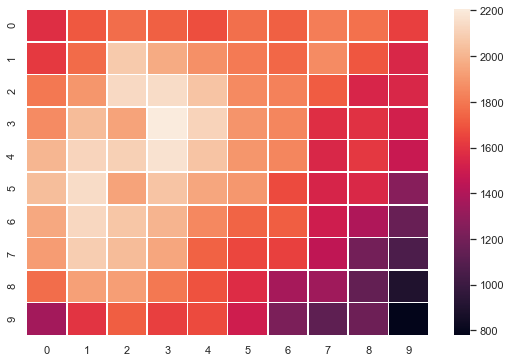

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()
data=pd.DataFrame(valor)
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data, annot=False, linewidths=.5, ax=ax)

In [63]:
#!pip3 install geojson --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [140]:
from geojson import Polygon, Feature, FeatureCollection

malla=[]
lat_max=40.521943
lat_min=40.402217
lng_max=-3.736493
lng_min=-3.658524
num_pasos=10
paso_lat=(lat_max-lat_min)/num_pasos
paso_lng=(lng_max-lng_min)/num_pasos


for i in range(num_pasos):
    for k in range(num_pasos):
        el_cubo=Polygon([[(lng_min + ( float(i) - 0.5)*paso_lng, lat_min + (float(k)-0.5)*paso_lat),
                          (lng_min + ( float(i) + 0.5)*paso_lng, lat_min + (float(k)-0.5)*paso_lat),
                          (lng_min + ( float(i) + 0.5)*paso_lng, lat_min + (float(k)+0.5)*paso_lat),
                          (lng_min + ( float(i) - 0.5)*paso_lng, lat_min + (float(k)+0.5)*paso_lat),
                          (lng_min + ( float(i) - 0.5)*paso_lng, lat_min + (float(k)-0.5)*paso_lat)]])
        
        malla.append( Feature(properties={"valor":valor[k][i]},geometry=el_cubo) )

malla_json= FeatureCollection(malla) 
    

In [119]:
#!pip3 install geopandas --user
#!pip3 install descartes --user
#!pip3 install contextily --user

You should consider upgrading via the 'pip install --upgrade pip' command.


### Creating the map for Madrid

In [130]:
import geopandas as gpd
import json
with open('madrid_json.json', 'w') as outfile:
    json.dump(malla_json, outfile)

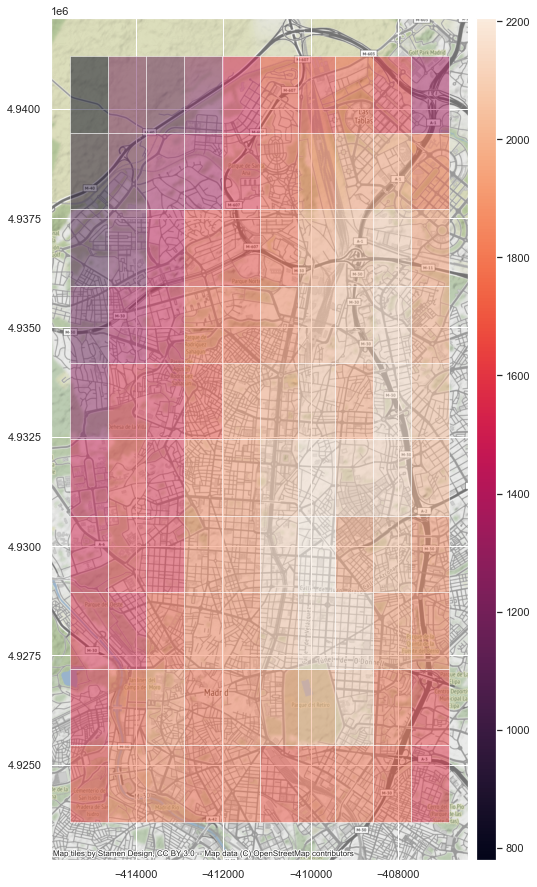

In [157]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
df1=gpd.read_file('madrid_json.json')
df1 = df1.to_crs(epsg=3857)

fig,ax1=plt.subplots(1, 1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax1=df1.plot(column='valor', alpha=0.5, ax=ax1,legend=True, cax=cax)
fig.set_size_inches(10.5, 15.5)
ctx.add_basemap(ax1)

## Estimation for New York

In [ ]:
import sys
sys.path.insert(0, 'src/')
from funobjetivo import fun_objetivo
import research_tool
# La solución alternativa es valorar la función en una malla de puntos sobre cada ciudad.
# 1) Generación de la malla de puntos y sus valores

valor=[]
malla=[]
lat_max=40.859602
lat_min=40.641156
lng_max=-73.887981
lng_min=-74.025693
num_pasos=20
paso_lat=(lat_max-lat_min)/num_pasos
paso_lng=(lng_max-lng_min)/num_pasos

for i in range(num_pasos):
    linea_valor=[]
    for k in range(num_pasos):
        linea_valor.append(fun_objetivo([lat_min+k*paso_lat,lng_min+i*paso_lng]))
        
    valor.append(linea_valor)

1777.4648041709952
1. error in lat:40.6520783, lon:-74.025693 and item:('starbucks', 'text') search
error en starbucks, resultado de la consulta :0
1483.3204160377836
1. error in lat:40.663000600000004, lon:-74.025693 and item:('starbucks', 'text') search
error en starbucks, resultado de la consulta :0
1. error in lat:40.663000600000004, lon:-74.025693 and item:('basketball court', 'text') search
error en basquet, resultado de la consulta :0
989.067965111778
1. error in lat:40.6739229, lon:-74.025693 and item:('starbucks', 'text') search
error en starbucks, resultado de la consulta :0
1. error in lat:40.6739229, lon:-74.025693 and item:('basketball court', 'text') search
error en basquet, resultado de la consulta :0
824.9616853312515
1. error in lat:40.684845200000005, lon:-74.025693 and item:('basketball court', 'text') search
error en basquet, resultado de la consulta :0
846.4221015569235
1542.3698131774177
2054.059636670733
2147.2790913458757
2042.2220707361544
2159.1534855152927
21

In [ ]:
1+1

In [ ]:
valor